In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-17 15:13:22--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.6’

housing.csv.6       100%[===================>]   1.36M  --.-KB/s    in 0.01s   

2022-10-17 15:13:22 (117 MB/s) - ‘housing.csv.6’ saved [1423529/1423529]



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

- Read from CSV;
- Select necessary columns;
- Fill NaN as 0

In [2]:
df = pd.read_csv('housing.csv.5')
df = df[['latitude','longitude',
'housing_median_age','total_rooms',
'total_bedrooms','population',
'households','median_income',
'median_house_value','ocean_proximity']]
df = df.fillna(0)

- Do train/validation/test split with 60%/20%/20% distribution.

In [3]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(12384, 4128, 4128)

- Reset indexes;
- Apply the log tranform to median_house_value;
- Delete median_house_value from dataset

In [4]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

- import DictVectorizer
- turn Dataframes into matrixes

In [5]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
df_val.shape, (len(X_val), len(X_val[0]))     #ensure the shape is correct 

((4128, 9), (4128, 13))

# Question 1


In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [7]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [8]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# Answer: ocean_proximity=INLAND

# Question 2

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [11]:
y_pred = rf.predict(X_val)

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
np.sqrt(mean_squared_error(y_val, y_pred)).round(2)

0.25

In [14]:
# Answer: 0.25

# Question 3

In [17]:
from tqdm.auto import tqdm
rmse = []
for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse.append((n,np.sqrt(mean_squared_error(y_val, y_pred)).round(5)))

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
df_scores = pd.DataFrame(rmse, columns=['n_estimators', 'rmse'])

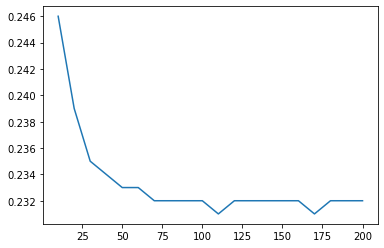

In [21]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [22]:
# Answer: 70

# Question 4

In [23]:
rmse = []
for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,max_depth=d,random_state=1, n_jobs=-1)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
df_scores = pd.DataFrame(rmse, columns=columns)

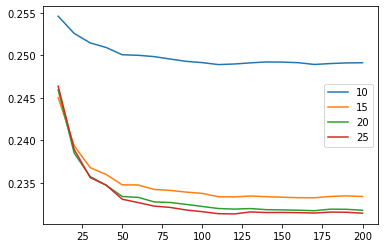

In [25]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)
plt.legend()

In [26]:
# Answer: 25

# Question 5

In [15]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [16]:
rf.feature_importances_

array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

In [17]:
df_imp = pd.DataFrame()
df_imp['feature'] = dv.get_feature_names()
df_imp['importance'] = rf.feature_importances_

/home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
df_imp.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145
10,population,0.030777
12,total_rooms,0.020541
11,total_bedrooms,0.019172
0,households,0.016387
9,ocean_proximity=NEAR OCEAN,0.004699


In [19]:
# Answer: median_income

# Question 6

In [24]:
!pip install xgboost

     |████████████████████████████████| 255.9 MB 45.5 MB/s eta 0:00:01   |▍                               | 2.8 MB 22.7 MB/s eta 0:00:12     |█▎                              | 10.6 MB 22.7 MB/s eta 0:00:11     |█▋                              | 12.7 MB 22.7 MB/s eta 0:00:11     |███▏                            | 25.4 MB 22.7 MB/s eta 0:00:11     |█████▌                          | 44.0 MB 17.0 MB/s eta 0:00:13     |█████▊                          | 46.2 MB 17.0 MB/s eta 0:00:13     |██████▎                         | 50.1 MB 17.0 MB/s eta 0:00:13     |██████▌                         | 52.2 MB 17.0 MB/s eta 0:00:12     |██████▉                         | 54.3 MB 17.0 MB/s eta 0:00:12     |███████                         | 56.5 MB 17.0 MB/s eta 0:00:12     |███████▉                        | 62.6 MB 17.0 MB/s eta 0:00:12     |█████████                       | 71.2 MB 17.0 MB/s eta 0:00:11     |█████████▏                      | 73.1 MB 17.0 MB/s eta 0:00:11     |█████████▍                    

In [ ]:
conda install -c conda-forge xgboost